<a href="https://colab.research.google.com/github/Danika-Balas/msds-458/blob/master/PCam_Dev10k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Data is a modified version of the PCam dataset--duplicates have been removed. The goal is to classify the images as cancerous or non-cancerous. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.
https://www.kaggle.com/c/histopathologic-cancer-detection/data?select=train_labels.csv 

###Acknowledgements
Code was adapted from the following notebooks:

https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch


#Setup and Preprocessing

In [249]:
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
#%matplotlib inline
#sns.set(style="whitegrid")

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import os, random
from random import shuffle
import cv2 #image processing
from glob import glob #for easily finding matching filenames 
from tqdm import tqdm, tqdm_notebook, trange #progress bar
import gc #garbage collection, for saving RAM

import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.3.0-tf'

In [0]:
from keras import metrics
from keras import models
from keras import layers

##Upload data

In [251]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Code executed once to unzip the files, then commented out:

In [0]:
# #unzip set of training files (smaller dataset to make sure it works)
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/sampleTrain.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain"

In [253]:
#Check whether sample files are readable
sample_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain/sampleTrain')
print(f'{len(sample_names)} files in sample directory')
print(sample_names[:5])

10 files in sample directory
['00a0ad1de2cdf805f02c524a985bca5bce1d1b5f.tif', '0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0.tif', '0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif', '0a0d1a09e5cf9fcc308ecdc210450aecd204d344.tif', '0a0b4604d66cecfe668e26383c22fafb74484eef.tif']


Starting with 10,000 training files in order develop model

Be sure to change path below when adding more files

In [0]:
# #unzip set of training files
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/train10.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/train"

In [0]:
# drive.mount("/content/drive", force_remount=True)

In [256]:
#Check whether sample files are readable
train_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/train/train10')
print(f'{len(train_names)} files in training directory')
print(train_names[:5])

10000 files in training directory
['98fd60e94bfb24264403c55339c1796eb600b456.tif', '98c96c61647457e6c4a4d277c373834069eca0a8.tif', '98e570bcbc7f928a0caff3fec9e6f3b0e9abc66d.tif', '98defffe091541cc07bae3c7e73993462c7ede91.tif', '98ce67acddba7d19ce88c35ecfea0540d1e631d1.tif']


Code below to unzip testing data. It has not been run yet it order to save space on Drive.

In [0]:
# #unzip set of testing files 
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/test.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/test"

In [0]:
# #Check whether sample files are readable
# test_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/test')
# print(f'{len(test_names)} files in testing directory')
# print(test_names[:5])

##Set paths

In [0]:
path = '/content/drive/My Drive/MSDS 458/PCam/unzipped/'
train_path = path+'train/train10'
test_path =  path+'test/'
sample_path = path+'sampleTrain/sampleTrain'  #contains 10 images, simply for testing data can be read

##Load labels and filenames

In [0]:
labels = pd.read_csv('/content/drive/My Drive/MSDS 458/PCam/train_labels.csv')

In [261]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[9].split(".")[0]) # keep only the file names in 'id'
df.head()

,path,id
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,98fd60e94bfb24264403c55339c1796eb600b456
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,98c96c61647457e6c4a4d277c373834069eca0a8
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,98e570bcbc7f928a0caff3fec9e6f3b0e9abc66d
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,98defffe091541cc07bae3c7e73993462c7ede91
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,98ce67acddba7d19ce88c35ecfea0540d1e631d1


In [0]:
df = df.merge(labels, on = "id") # merge labels and filepaths

In [263]:
df.head(5) # print the first five entries

,path,id,label
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,98fd60e94bfb24264403c55339c1796eb600b456,0
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,98c96c61647457e6c4a4d277c373834069eca0a8,0
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,98e570bcbc7f928a0caff3fec9e6f3b0e9abc66d,0
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,98defffe091541cc07bae3c7e73993462c7ede91,1
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,98ce67acddba7d19ce88c35ecfea0540d1e631d1,1


In [264]:
print(df.count) #check total number of rows in dataframe

<bound method DataFrame.count of                                                    path  ... label
0     /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
1     /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
2     /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
3     /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
4     /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
...                                                 ...  ...   ...
9995  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
9996  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
9997  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
9998  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
9999  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1

[10000 rows x 3 columns]>


##Load images

In [0]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    dfLabel=df['label']
    y = np.squeeze(dfLabel.to_numpy())[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [266]:
# Load some of the images
N=1000
X,y = load_data(N=N,df=df) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


##EDA

View some sample images. Non-cancerous samples are labeled 0, and cancerous samples are labeled 1.

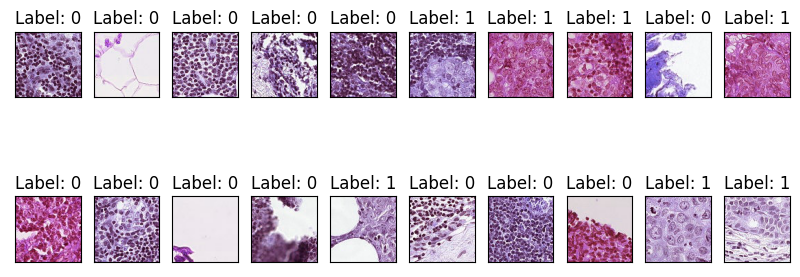

In [267]:
fig = plt.figure(figsize=(10, 4), dpi=100)
np.random.seed(777) #we can use the seed to get a different set of random images
for plotNr,idx in enumerate(np.random.randint(0,N,20)):
    ax = fig.add_subplot(2, 20//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image

Evaluate the distribution of the two classes

Text(0, 0.5, 'Samples')

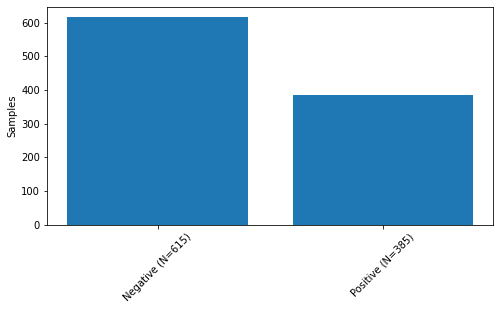

In [268]:
plt.figure(figsize=[8,4])
plt.bar([0,1], [(y==0).sum(), (y==1).sum()])
plt.axis()
plt.xticks([0,1],[f"Negative (N={(y==0).sum()})",f"Positive (N={(y==1).sum()})"],rotation=45)
#plt.xticks(rotation=45)
#plt.rc('xtick',labelsize=10)
plt.ylabel('Samples')


In [269]:
print(f"{(y==1).sum()/y.sum()*100} percent of the samples are positive.")

100.0 percent of the samples are positive.


###To evaluate the classes individually

In [0]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

Look at the distribution of the pixels for each color channel

In [0]:
# nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
# fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

# #RGB channels
# axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
# axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
# axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
# axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
# axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
# axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

# #All channels
# axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
# axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

# #Set image labels
# axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
# axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
# axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
# axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
# axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
# axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
# for i in range(4):
#     axs[i,0].set_ylabel("Relative frequency")
# axs[3,0].set_xlabel("Pixel value")
# axs[3,1].set_xlabel("Pixel value")
# fig.tight_layout()

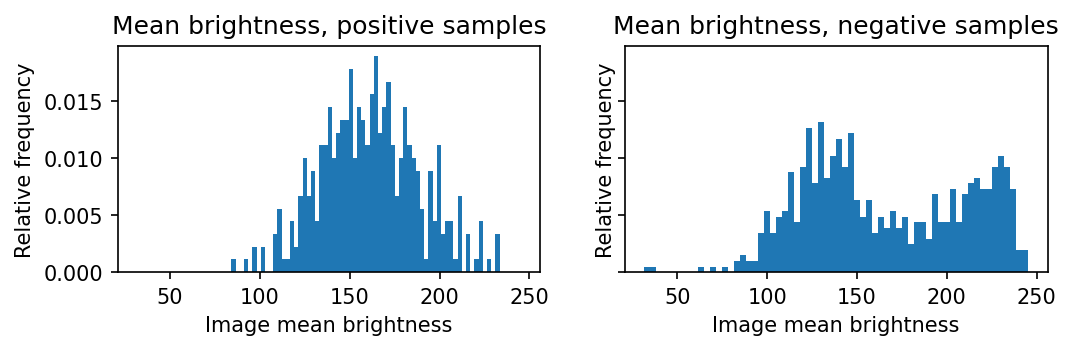

In [272]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

In [0]:
#Clean up variables to free up RAM
#Collect garbage
positives_samples = None
negative_samples = None
gc.collect();

#Prepare data for modeling

In [274]:
#Load remainder of dataset
N = df["path"].size # get the number of images in the training data set
X,y = load_data(N=N,df=df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


##Train test split

In [0]:
# Split into train and test (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [276]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 96, 96, 3), (2000, 96, 96, 3), (8000,), (2000,))

#Define callbacks for training/testing times

In [0]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [0]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

#Experiment 1:DNN
Establish a baseline

##Build and compile the model

In [279]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(96, 96, 3)))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 27648)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               2764900   
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
Total params: 2,765,001
Trainable params: 2,765,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [281]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 6800 samples, validate on 1200 samples
Epoch 1/15
6800/6800 [==============================] - 1s 107us/step - loss: 560.4187 - accuracy: 0.5459 - val_loss: 366.1000 - val_accuracy: 0.3933
Epoch 2/15
6800/6800 [==============================] - 1s 85us/step - loss: 173.0504 - accuracy: 0.5525 - val_loss: 29.0049 - val_accuracy: 0.5958
Epoch 3/15
6800/6800 [==============================] - 1s 84us/step - loss: 72.3061 - accuracy: 0.5781 - val_loss: 173.3016 - val_accuracy: 0.6067
Epoch 4/15
6800/6800 [==============================] - 1s 84us/step - loss: 161.1012 - accuracy: 0.5731 - val_loss: 77.3560 - val_accuracy: 0.6075
Epoch 5/15
6800/6800 [==============================] - 1s 82us/step - loss: 75.4576 - accuracy: 0.5885 - val_loss: 118.6177 - val_accuracy: 0.3958
Epoch 6/15
6800/6800 [==============================] - 1s 86us/step - loss: 86.0809 - accuracy: 0.5846 - val_loss: 57.8649 - val_accuracy: 0.6008
Epoch 7/15
6800/6800 [==============================] - 1s 81us

In [282]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

8.703477

##Test the model

In [283]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

2000/2000 [==============================] - 0s 106us/step


(17.13296455383301, 0.6134999990463257)

In [284]:
test_time = test_rt.process_time
test_time # in seconds

0.214072

### Create a dataframe for the training and test statistics

In [285]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [286]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,val_loss,val_accuracy,loss,accuracy
10,68.857613,0.606667,36.701415,0.610000
11,87.447867,0.608333,42.827340,0.626912
12,132.670160,0.606667,32.146788,0.628676
13,16.101786,0.605000,48.868672,0.625000
14,16.384727,0.606667,31.130980,0.623529


In [287]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (1 layer)') 
results_df['test_loss'] = test_loss #incorporate test results
results_df['test_accuracy'] = test_acc
results_df['train time'] = train_time    
results_df['test time'] = test_time     
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,DNN (1 layer),16.384727,0.606667,31.13098,0.623529,17.132965,0.6135,8.703477,0.214072


### Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss/accuracy for each training epoch side by side.

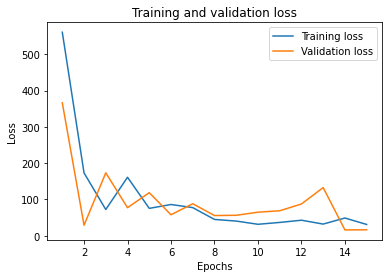

In [288]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

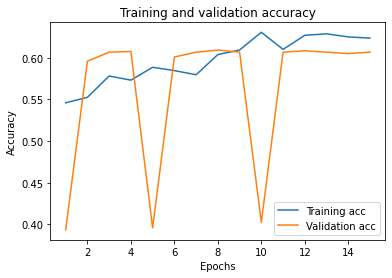

In [289]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

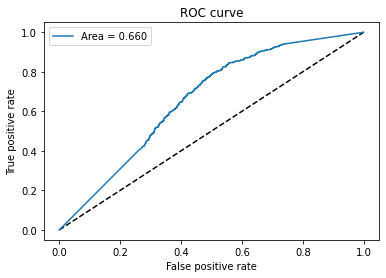

In [292]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#Experiment 2, second DNN

This model is the same as in Experiment 1, but with an additional hidden layer. First hidden layer has 200 nodes, second hidden layer has 100 nodes.

##Build and compile the model

In [293]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(96, 96, 3)))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 27648)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 200)               5529800   
_________________________________________________________________
dense_35 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 101       
Total params: 5,550,001
Trainable params: 5,550,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [295]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 6800 samples, validate on 1200 samples
Epoch 1/15
6800/6800 [==============================] - 1s 121us/step - loss: 886.0594 - accuracy: 0.5500 - val_loss: 29.8526 - val_accuracy: 0.5950
Epoch 2/15
6800/6800 [==============================] - 1s 99us/step - loss: 88.3553 - accuracy: 0.5581 - val_loss: 93.3366 - val_accuracy: 0.6067
Epoch 3/15
6800/6800 [==============================] - 1s 104us/step - loss: 41.3894 - accuracy: 0.5722 - val_loss: 65.5486 - val_accuracy: 0.6067
Epoch 4/15
6800/6800 [==============================] - 1s 96us/step - loss: 80.9811 - accuracy: 0.5599 - val_loss: 125.1726 - val_accuracy: 0.6067
Epoch 5/15
6800/6800 [==============================] - 1s 100us/step - loss: 43.5034 - accuracy: 0.5859 - val_loss: 8.6601 - val_accuracy: 0.6050
Epoch 6/15
6800/6800 [==============================] - 1s 103us/step - loss: 35.6304 - accuracy: 0.5700 - val_loss: 64.0834 - val_accuracy: 0.3933
Epoch 7/15
6800/6800 [==============================] - 1s 99us/s

In [296]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

10.441911

##Test the model

In [297]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

2000/2000 [==============================] - 0s 109us/step


(0.965983338356018, 0.5755000114440918)

In [298]:
test_time = test_rt.process_time
test_time # in seconds

0.218529

###Add training and test statistics to results dataframe

In [299]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','DNN (2 layers)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,DNN (2 layers),0.919493,0.596667,0.691228,0.698676,0.965983,0.5755,10.441911,0.218529


In [300]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),16.384727,0.606667,31.130980,0.623529,17.132965,0.6135,8.703477,0.214072
1,DNN (2 layers),0.919493,0.596667,0.691228,0.698676,0.965983,0.5755,10.441911,0.218529


### Plotting the performance 


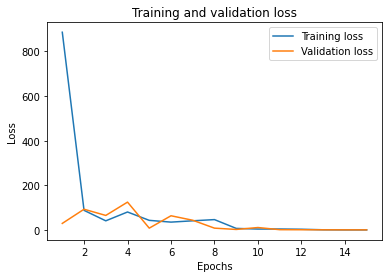

In [301]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

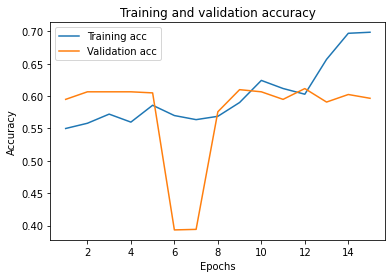

In [302]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

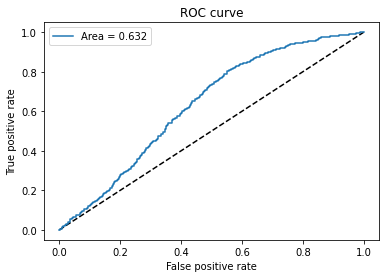

In [305]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#Experiment 3: CNN with 2 convolutional layers

In [306]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 30976)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               7930112   
_________________________________________________________________
dense_38 (Dense)             (None, 1)               

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [308]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 6800 samples, validate on 1200 samples
Epoch 1/15
6800/6800 [==============================] - 2s 255us/step - loss: 38.3950 - accuracy: 0.6300 - val_loss: 0.5538 - val_accuracy: 0.7300
Epoch 2/15
6800/6800 [==============================] - 1s 219us/step - loss: 0.5024 - accuracy: 0.7538 - val_loss: 0.5347 - val_accuracy: 0.7458
Epoch 3/15
6800/6800 [==============================] - 1s 220us/step - loss: 0.4274 - accuracy: 0.8128 - val_loss: 0.5256 - val_accuracy: 0.7700
Epoch 4/15
6800/6800 [==============================] - 2s 221us/step - loss: 0.3857 - accuracy: 0.8253 - val_loss: 0.5892 - val_accuracy: 0.7433
Epoch 5/15
6800/6800 [==============================] - 1s 220us/step - loss: 0.3316 - accuracy: 0.8628 - val_loss: 0.5891 - val_accuracy: 0.7725
Epoch 6/15
6800/6800 [==============================] - 2s 222us/step - loss: 0.2919 - accuracy: 0.8800 - val_loss: 0.5727 - val_accuracy: 0.7708
Epoch 7/15
6800/6800 [==============================] - 2s 223us/step - los

In [309]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

22.954449

##Test the model

In [310]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

2000/2000 [==============================] - 0s 158us/step


(1.4900504379272461, 0.7365000247955322)

In [311]:
test_time = test_rt.process_time
test_time # in seconds

0.316235

###Add training and test statistics to results dataframe

In [312]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','CNN (2 layers)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,CNN (2 layers),1.574971,0.711667,0.051818,0.986471,1.49005,0.7365,22.954449,0.316235


In [313]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),16.384727,0.606667,31.130980,0.623529,17.132965,0.6135,8.703477,0.214072
1,DNN (2 layers),0.919493,0.596667,0.691228,0.698676,0.965983,0.5755,10.441911,0.218529
2,CNN (2 layers),1.574971,0.711667,0.051818,0.986471,1.490050,0.7365,22.954449,0.316235


### Plotting the performance 


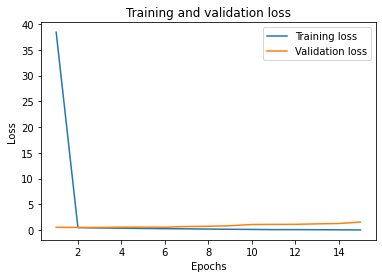

In [314]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

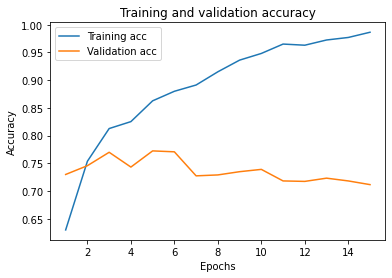

In [315]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

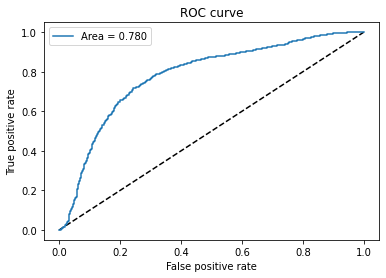

In [318]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#Experiment 4: CNN with 2 convolutional layers, dropout

In [319]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 30976)           

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [321]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 6800 samples, validate on 1200 samples
Epoch 1/15
6800/6800 [==============================] - 2s 290us/step - loss: 77.4875 - accuracy: 0.5966 - val_loss: 0.7012 - val_accuracy: 0.3975
Epoch 2/15
6800/6800 [==============================] - 2s 248us/step - loss: 0.5996 - accuracy: 0.6644 - val_loss: 0.7529 - val_accuracy: 0.3933
Epoch 3/15
6800/6800 [==============================] - 2s 246us/step - loss: 0.5823 - accuracy: 0.7038 - val_loss: 0.8613 - val_accuracy: 0.3950
Epoch 4/15
6800/6800 [==============================] - 2s 251us/step - loss: 0.5543 - accuracy: 0.7347 - val_loss: 0.9980 - val_accuracy: 0.3958
Epoch 5/15
6800/6800 [==============================] - 2s 243us/step - loss: 0.5508 - accuracy: 0.7360 - val_loss: 1.1274 - val_accuracy: 0.3958
Epoch 6/15
6800/6800 [==============================] - 2s 243us/step - loss: 0.5330 - accuracy: 0.7460 - val_loss: 1.2419 - val_accuracy: 0.3958
Epoch 7/15
6800/6800 [==============================] - 2s 245us/step - los

In [322]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

25.347958

##Test the model

In [323]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

2000/2000 [==============================] - 0s 162us/step


(1.443521912574768, 0.4440000057220459)

In [324]:
test_time = test_rt.process_time
test_time # in seconds

0.3245

###Add training and test statistics to results dataframe

In [325]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','CNN (2 layers, D)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,"CNN (2 layers, D)",1.5252,0.415,0.482424,0.778235,1.443522,0.444,25.347958,0.3245


In [326]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),16.384727,0.606667,31.130980,0.623529,17.132965,0.6135,8.703477,0.214072
1,DNN (2 layers),0.919493,0.596667,0.691228,0.698676,0.965983,0.5755,10.441911,0.218529
2,CNN (2 layers),1.574971,0.711667,0.051818,0.986471,1.490050,0.7365,22.954449,0.316235
3,"CNN (2 layers, D)",1.525200,0.415000,0.482424,0.778235,1.443522,0.4440,25.347958,0.324500


### Plotting the performance 


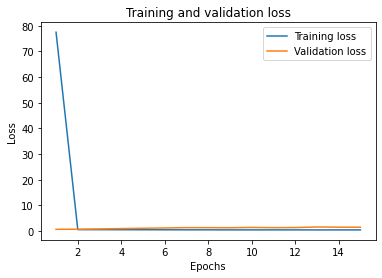

In [327]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

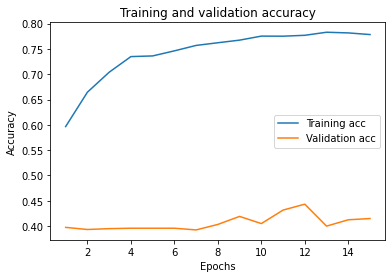

In [328]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

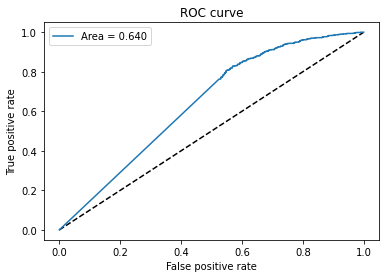

In [331]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()